# Homework 4

In this homework we will practice basic analysis such as feature extraction and data transforms (Fourier, wavelet), and feature extraction.


**1. Ice-shelf seismograms** (10 points)

Time-domain filtering, 1D Fourier transform.

**2. TEC from the Hunga-Tunga explosion** (10 points)

Time-domain filtering, 1D wavelet transform.

**3. 2D Crustal model** (10 points)

practice reading netcdf, making maps and exploring 2D spectral content.



## 1) Time Frequency analysis of iceshelf vibrations 

We will explore the spectral content of the vibrations felt on iceshelves. We first download seismic data, then filter it at different frequency bandwidths, then plot the spectrogram and comment on the data.

The seismic data is handled by the Obspy package. Review the obspy tutorial that Ariane.
We will download the data presented in: Aster, R.C., Lipovsky, B.P., Cole, H.M., Bromirski, P.D., Gerstoft, P., Nyblade, A., Wiens, D.A. and Stephen, R., 2021. Swell‐Triggered Seismicity at the Near‐Front Damage Zone of the Ross Ice Shelf. Seismological Research Letters. https://doi.org/10.1785/0220200478

__Tips__:
1. Check out the SciPy filtering help here: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html. Obspy has built in functions as well, but for the sake of practicing, explore the scipy filtering functions.

2. The usual steps to handling seismic data are: data download (``get_waveforms``) & removing the instrumental response (``remove_response``).




**a. Import the relevant Obspy python modules (1 point).**

In [2]:
# Import the Obspy modules that will be useful to download seismic data
import obspy
import obspy.clients.fdsn.client as fdsn
fdsn_client = fdsn.Client('IRIS') # client to query the IRIS DMC server) 
from obspy import UTCDateTime

# import other useful modules
import numpy as np
import pandas as pd

**b. Data download (1 point)**

We will now download the data from station "DR01" from seismic network "XH", channel "LHN" from 1/1/2015 until 3/31/2015. The client will be the "IRIS" data center. Obspy functions take on UTCDateTime formatted obspy datetime object, be sure to call or import that specific function. (1 point)

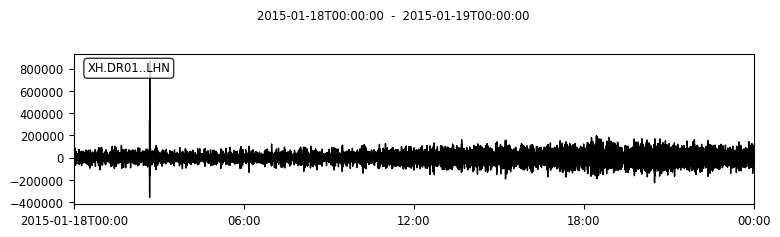

1 Trace(s) in Stream:
XH.DR01..LHN | 2015-01-18T00:00:00.000000Z - 2015-01-19T00:00:00.000000Z | 1.0 Hz, 86401 samples

In [3]:
# answer below
net = 'XH'
sta = 'DR01'
cha = 'LHN'
t_start = UTCDateTime('2015-01-18')
t_end = UTCDateTime('2015-01-19') # 
st = fdsn_client.get_waveforms(net, sta, '', cha, t_start, t_end, attach_response=True)
st.plot() # plot seismogram
st

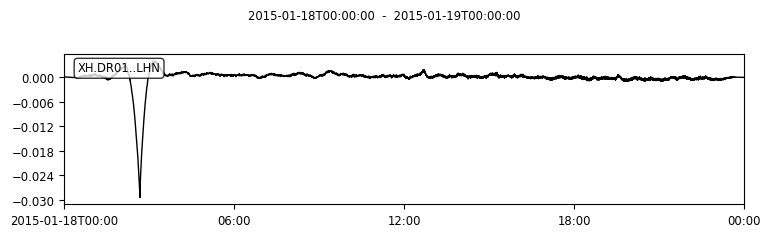

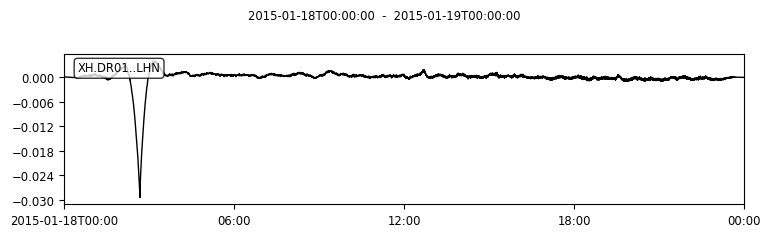

In [4]:
# seismic preprocessing
st.merge() # mrge traces together
st.detrend(type='linear') # detrend linear
st[0].taper(max_percentage=0.05) # taper 5%
st[0].remove_response() # remove instrument response
tr = st[0]
st.plot()

In [5]:
# # downsampling
# st_d = st.copy() # copy original trace because resample overwrites
# st_d = st_d.resample(0.25, window='hann') # resample data to 0.25 Hz to reduce data (easier to plot)
# #st.decimate(4)
# st_d.plot() # downsampled stream
# tr = st_d[0] # downsampled
# st # check length of oringinal stream

In [6]:
# how many days did we download?
dt=t_end-t_start # in seconds
Ndays = int(dt/86400) # in days
print(Ndays)

1


**c. Time series filtering (2 points)**

Now we will filter the trace to explore its frequency content. We will apply 3 filters:
1. a ``lowpass`` filter to look at seismic frequencies below 0.01Hz, or 100 s period

2. a ``bandpass`` filter to look at seismic frequencies between 0.01Hz-0.1 Hz (10-100s)

3. a ``highpass`` filter to look at seismic frequencies higher than 0.1 Hz (10s) and until the time series Nyquist frequency (0.5Hz since the data is sampled at 1 Hz).

In [7]:
# plotting modules
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8) # set default figure size
plt.rcParams.update({'font.size': 12}) # set default font size

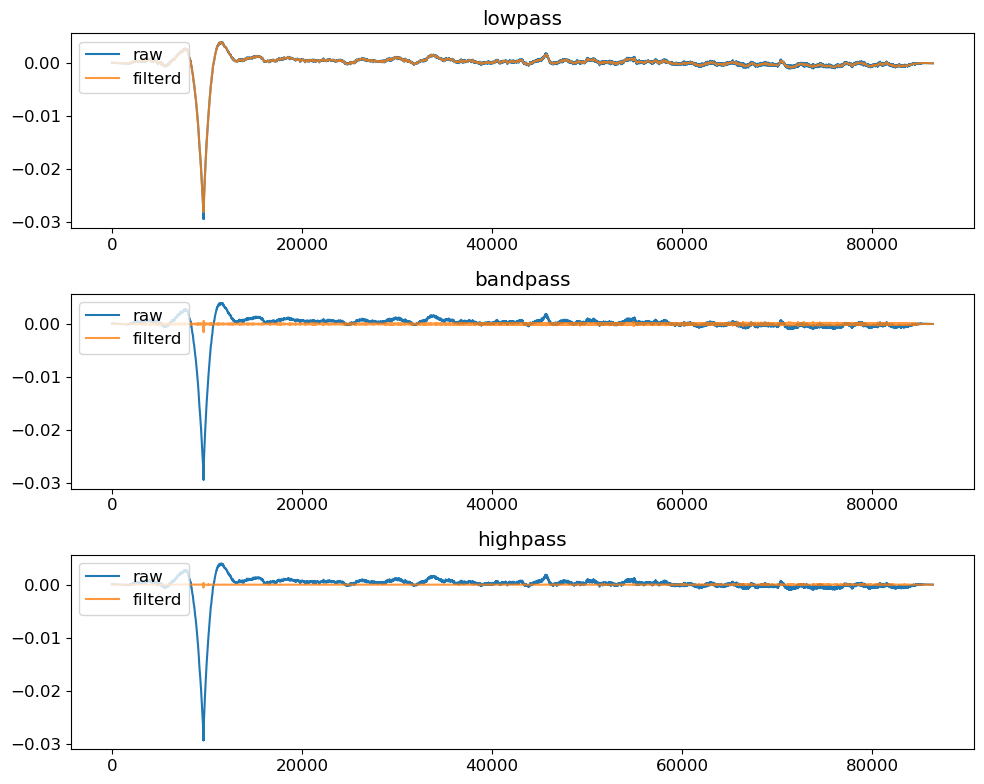

In [8]:
# answer below
from scipy.signal import butter,buttord,  sosfiltfilt, freqs

fs = tr.stats['sampling_rate'] # sampling rate

filter_type = ['lowpass','bandpass','highpass']
frequencies = [0.01, [0.01, 0.1], 0.1]
fig, ax = plt.subplots(len(filter_type))
filtered_l = [tr.data]

for i in range(len(filter_type)):
    sos = butter(2, frequencies[i], filter_type[i], fs=fs, output='sos')
    filtered = sosfiltfilt(sos, tr.data)
    filtered_l.append(filtered)

    ax[i].plot(tr.times(),tr.data, label='raw')
    ax[i].plot(tr.times(),filtered, label='filterd', alpha=0.8)
    ax[i].set_title(filter_type[i])
    ax[i].legend(loc='upper left')
plt.tight_layout()

# Here we use a Butterworth filter to select the spectral content of the waveform. 
# I like to use Buttord because it finds the order of the filter that meets the amplitude reduction criterion
# it's a lot more intuitive! https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.buttord.html


In [9]:
filtered_l # raw, lowpass, bandpass, highpass

[array([1.07371832e-04, 1.07367040e-04, 1.07361767e-04, ...,
        4.98303661e-06, 4.93681220e-06, 4.89113930e-06]),
 array([1.07366280e-04, 1.07361090e-04, 1.07355670e-04, ...,
        5.54728347e-06, 5.53990519e-06, 5.53367322e-06]),
 array([-7.38346774e-09, -6.42986781e-09, -5.39480371e-09, ...,
         1.46376748e-09,  1.79672271e-09,  2.13302418e-09]),
 array([ 4.03801462e-11,  3.26158278e-10,  2.25608593e-10, ...,
         5.21319047e-11, -2.34003184e-10, -7.18573265e-13])]

**c. Fourier transform (3 points)**


Perform and the Fourier amplitude spectrum of the seismogram. Don't forget to label the figure properly! Use the Fourier frequency vector for x-axis. Use the tutorials for inspirtion.

In [10]:
# import FFT modules
# answer below
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len

fft_l = [] # raw, lowpass, bandpass, highpass

npts = tr.stats.npts
Nfft = next_fast_len(int(tr.data.shape[0])) # fill up until 2^N value to speed up the FFT
freqVec = fftfreq(Nfft, d=tr.stats.delta)[:Nfft//2]

for i in range(len(filtered_l)):
    fft_tr = fft(filtered_l[i],n=Nfft)
    fft_tr = np.abs(fft_tr[:Nfft//2])/Nfft
    fft_l.append(fft_tr)


Text(0, 0.5, 'Amplitude (m/s)')

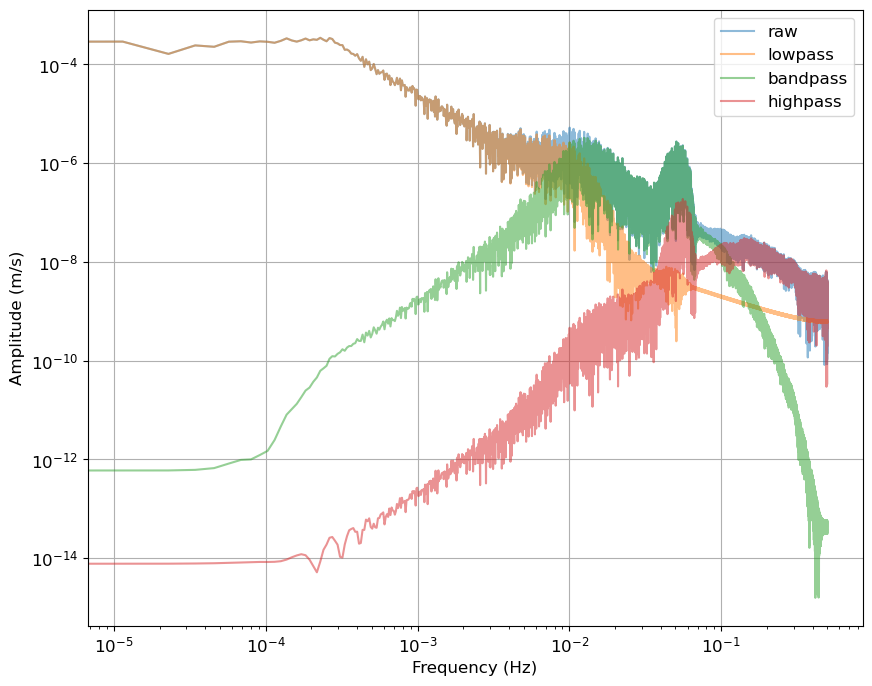

In [11]:
fig,ax = plt.subplots()
ax.plot(freqVec,fft_l[0], label='raw', alpha=0.5)
ax.plot(freqVec,fft_l[1], label=filter_type[0], alpha=0.5)
ax.plot(freqVec,fft_l[2], label=filter_type[1], alpha=0.5)
ax.plot(freqVec,fft_l[3], label=filter_type[2], alpha=0.5)
ax.grid(True)
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (m/s)')

Comment on the spectral content of the seismograms. How does the relative contribution of the low, intermediate, and high frequency signal compares with the relative amplitude observed in the bandpass filtered time series?

### answer
- lowpass: We see the low frequencies. The low frequencies are not affected by the filter but the hig frequencies are missing.
- bandpass: low and hight frequencies are missing.
- highpass: We see the high frequencies and filterinc artifacts at low frequencies.

**d. Synthetic noise (3 points)**

We have now a good idea of what the amplitude of seismic waves are at this station. Now create a noise signal using the Fourier amplitude spectrum of the seismic signal, and with a random phase. You can use the notes from our first Numpy example (2.7_data_transforms.ipynb)

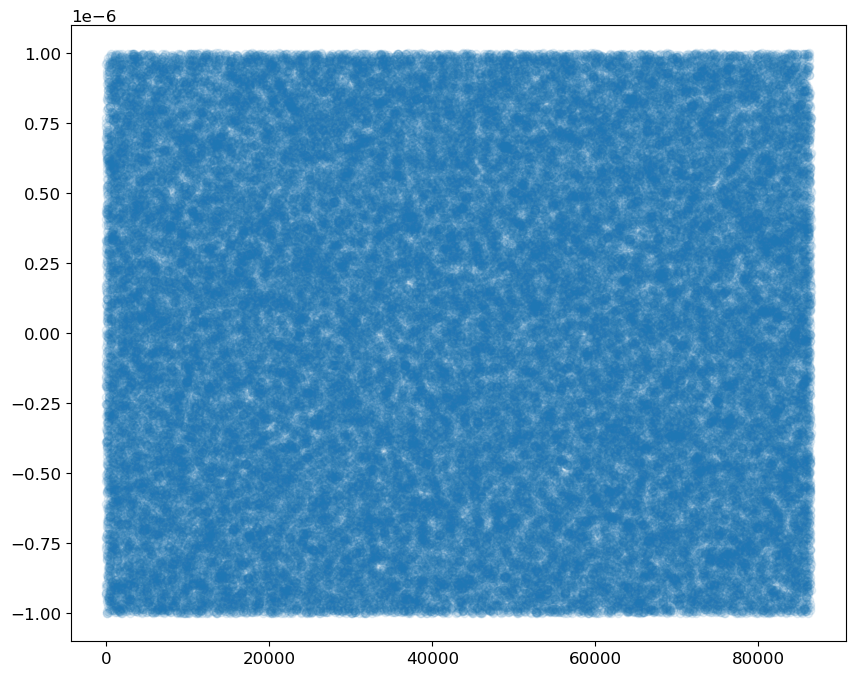

In [12]:

# answer below
from numpy import random
from scipy.fftpack import ifft,ifftshift 

rand_noise = random.uniform(-1,1,len(tr))/1e6
tr_n = tr.data+rand_noise
plt.plot(rand_noise, 'o', alpha=0.1)

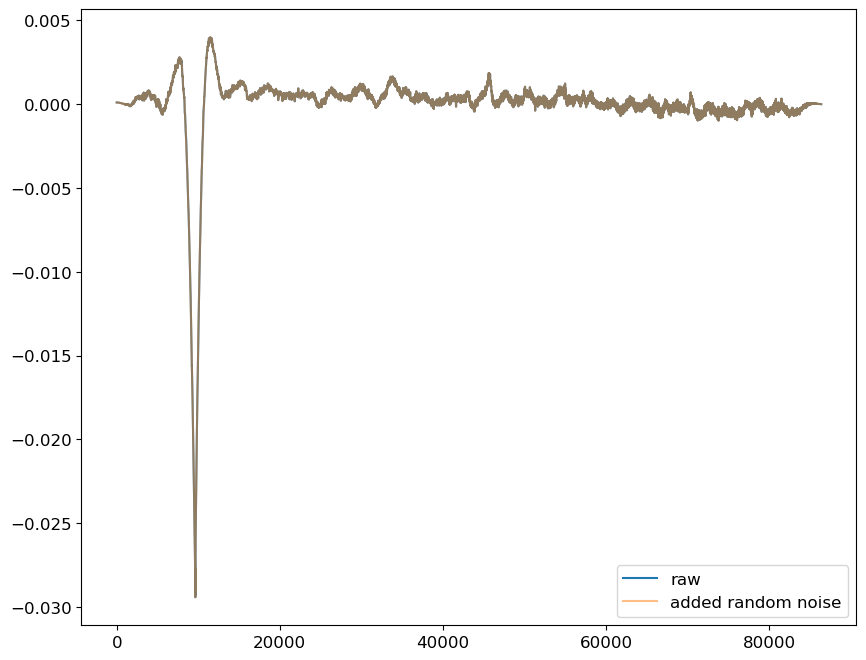

In [13]:
plt.plot(tr.times(),tr.data, label='raw')
plt.plot(tr.times(), tr_n, label='added random noise', alpha=0.5)
plt.legend(loc='lower right')

**e. !Sanity check! (1 point)**

Check that the Fourier amplitude spectrum of the noise is that of the original window. Overlay them on a plot 

In [14]:
for i in range(len(filtered_l)):
    fft_n = fft(tr_n,n=Nfft)
    fft_n = np.abs(fft_n[:Nfft//2])/Nfft

Text(0, 0.5, 'Amplitude (m/s)')

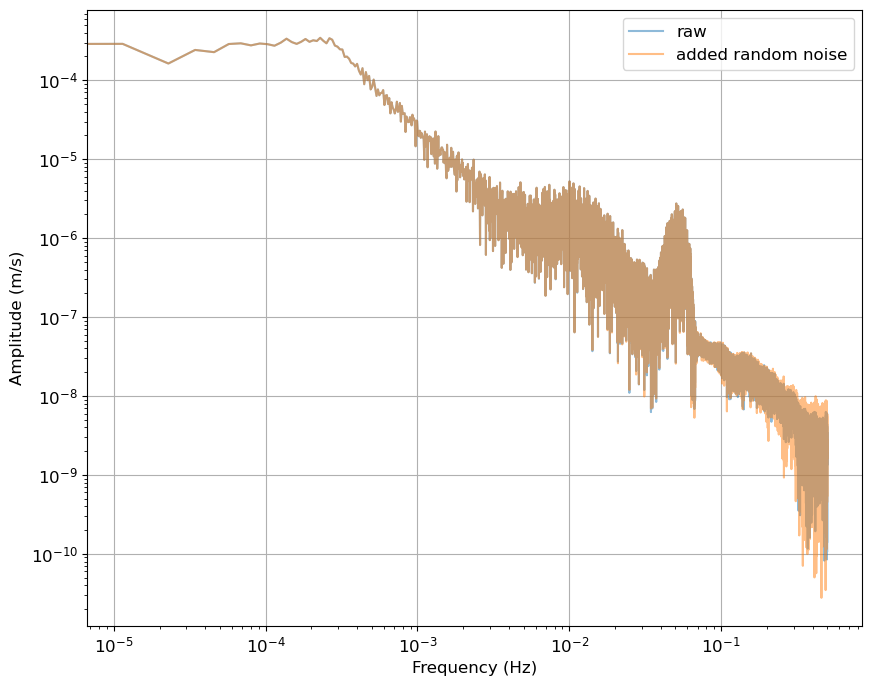

In [15]:
# answer below
fig,ax = plt.subplots()
ax.plot(freqVec,fft_l[0], label='raw', alpha=0.5)
ax.plot(freqVec,fft_n, label='added random noise', alpha=0.5)
ax.grid(True)
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (m/s)')

**f. Short Time Fourier Transform (3 points)**

STFT are important transforms that are used in data science of time series. They are mainly used for denoising and for feature extraction.
Spectrograms are STFT with window overlap.

/tmp/ipykernel_90/3776431626.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, np.log10(np.abs(Sxx)), cmap='plasma', vmin=-10, vmax=-2)


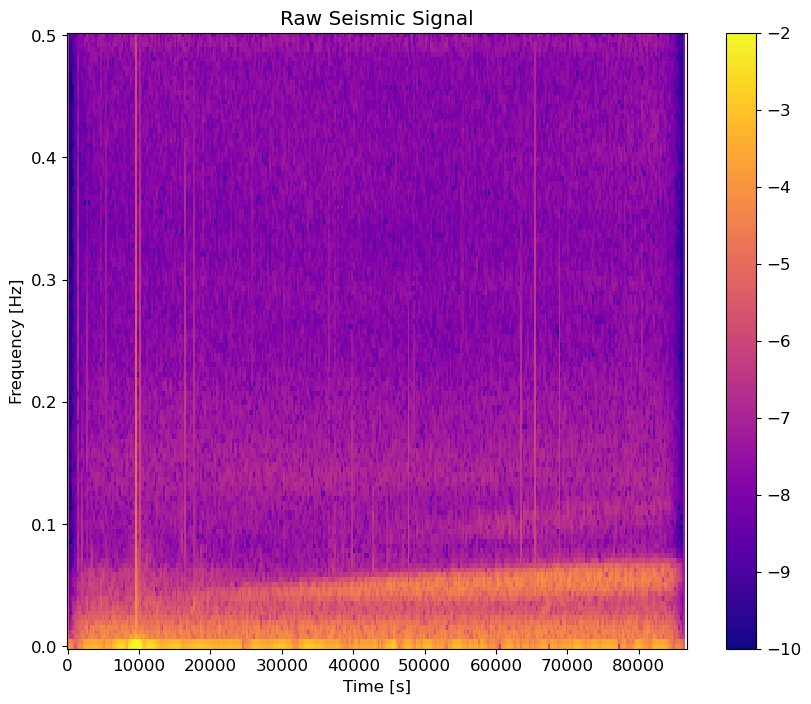

In [16]:
# answer below
from scipy.signal import stft
f, t, Sxx = stft(tr.data, fs=fs, noverlap=10)
#plt.imshow(np.log10(np.abs(Sxx)), cmap='plasma', aspect='auto',origin='lower')
plt.pcolormesh(t, f, np.log10(np.abs(Sxx)), cmap='plasma', vmin=-10, vmax=-2)
plt.title('Raw Seismic Signal')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar()

/tmp/ipykernel_90/3893515078.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, np.log10(np.abs(Nxx)), cmap='plasma', vmin=-10, vmax=-2)


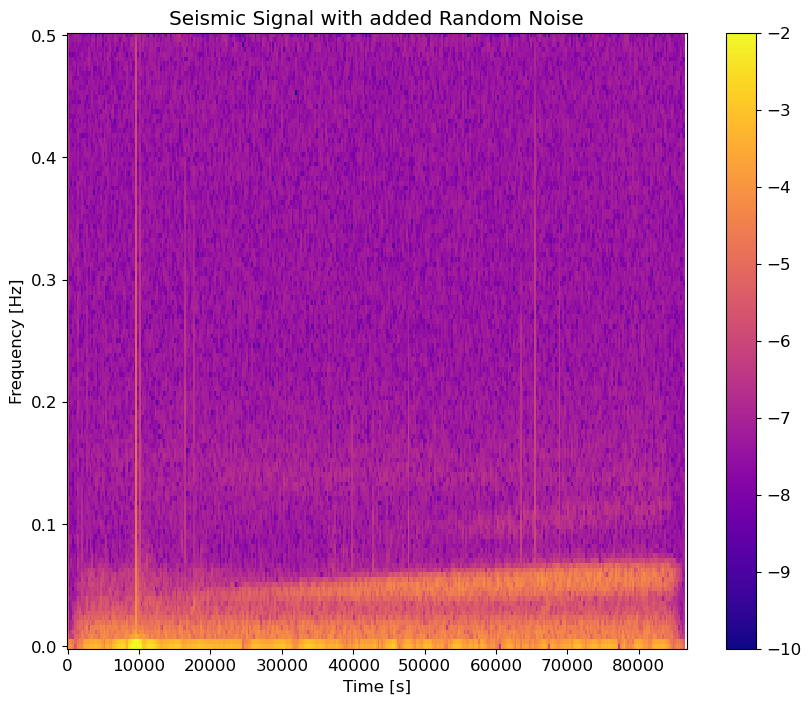

In [17]:
f, t, Nxx = stft(tr_n, fs=fs, noverlap=10)
plt.pcolormesh(t, f, np.log10(np.abs(Nxx)), cmap='plasma', vmin=-10, vmax=-2)
plt.title('Seismic Signal with added Random Noise')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar()

Now you have created a 2D image of a time series! Many seismologists use that as input to convolutional neural networks.



## 2. Time Series analysis of Hunga- Tonga
 Ghent and Crowell, 2022: TF representation of the TEC (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL100145). The Total Electron Content (TEC) is the total number of electrons present along a path between a radio transmitter and receiver. TEC is measured in electrons per square meter. By convention, 1 TEC Unit TECU = 10^16 electrons/m². Vertical TEC values in Earth’s ionosphere can range from a few to several hundred TECU.

 On 15 January 2022, Tonga's Hunga Tonga-Hunga Ha'apai (HTHH) volcano violently erupted, generating a tsunami that killed three people. Acoustic-gravity waves propagated by the eruption and tsunami caused global complex ionospheric disturbances. In this paper, we study the nature of these perturbations from Global Navigation Satellite System observables over the southwestern Pacific. After processing data from 818 ground stations, we detect supersonic acoustic waves, Lamb waves, and tsunamis, with filtered magnitudes between 1 and 7 Total Electron Content units.

Apply the Fourier and Wavelet transforms to the TEC time series observed a a GPS section..


### a. Read the data (1 point)

Read the CSV file file ``./TEC/ioncorr_samo_015_2022_tonga.csv``, print the keys of the data frame. THe key ``time`` is a timestamp of seconds since epoch time (1970/01/01). The data shown in the article is in the Series ``variometric_derived_TEC``. **samo** is the name of the GPS receiver. There are up to 32 satellite data saved in the CSV file.

Plot the first 2 hours of the time series

In [18]:
# answer below
t_path = "./TEC/ioncorr_samo_015_2022_tonga.csv"
df = pd.read_csv(t_path)
df['datetime'] = pd.to_datetime(df['time'],unit='s') # convert timestamp to datetime in new column
#df = df.set_index('datetime')
#df = df.sort_index() # sort df by time
df = df.set_index('Unnamed: 0')
print(df.columns)
df.head()

Index(['GPS_seconds', 'satellite_number', 'variometric_derived_TEC',
       'variometric_derived_TEC_filtered', 'absolute_derived_TEC',
       'absolute_derived_TEC_filtered', 'latitude_piercing_point',
       'longitude_piercing_point', 'satellite_azimuth',
       'satellite_elevation_angle', 'distance_to_piercing_point', 'time',
       'datetime'],
      dtype='object')


GPS_seconds  satellite_number  variometric_derived_TEC  \
Unnamed: 0                                                            
0           1.326293e+09                 1                 0.012495   
1           1.326293e+09                 1                 0.040731   
2           1.326293e+09                 1                 0.053964   
3           1.326293e+09                 1                 0.077087   
4           1.326293e+09                 1                 0.076847   

            variometric_derived_TEC_filtered  absolute_derived_TEC  \
Unnamed: 0                                                           
0                                  -0.006029             -0.227013   
1                                   0.021995             -0.190032   
2                                   0.040939             -0.111259   
3                                   0.051804             -0.061669   
4                                   0.069999             -0.037234   

            absolute_derived_TEC_filtered  latitude_piercing_point  \
Unnamed: 0                                                           
0                                0.060790                  -6.2736   
1                                0.108237                  -6.3212   
2                                0.130265                  -6.3686   
3                                0.154675                  -6.4159   
4                                0.193697                  -6.4629   

            longitude_piercing_point  satellite_azimuth  \
Unnamed: 0                                                
0                          -170.1929              11.46   
1                          -170.1798              11.63   
2                          -170.1670              11.79   
3                          -170.1543              11.96   
4                          -170.1419              12.12   

            satellite_elevation_angle  distance_to_piercing_point  \
Unnamed: 0                                                          
0                               18.17                     1674.50   
1                               18.32                     1670.00   
2                               18.46                     1665.52   
3                               18.60                     1661.05   
4                               18.75                     1656.60   

                    time            datetime  
Unnamed: 0                                    
0           1.642286e+09 2022-01-15 22:37:00  
1           1.642286e+09 2022-01-15 22:37:30  
2           1.642286e+09 2022-01-15 22:38:00  
3           1.642286e+09 2022-01-15 22:38:30  
4           1.642286e+09 2022-01-15 22:39:00

In [19]:
# does not work because the index is not unique

# from datetime import datetime, timedelta
# print(df.index[0],df.index[0]+timedelta(hours=2))
# plt.plot(df.variometric_derived_TEC[df.index[0]:df.index[0]+timedelta(hours=2)])

7200 1642286220.0 1642293420.0


Text(0, 0.5, 'variometric derived TEC')

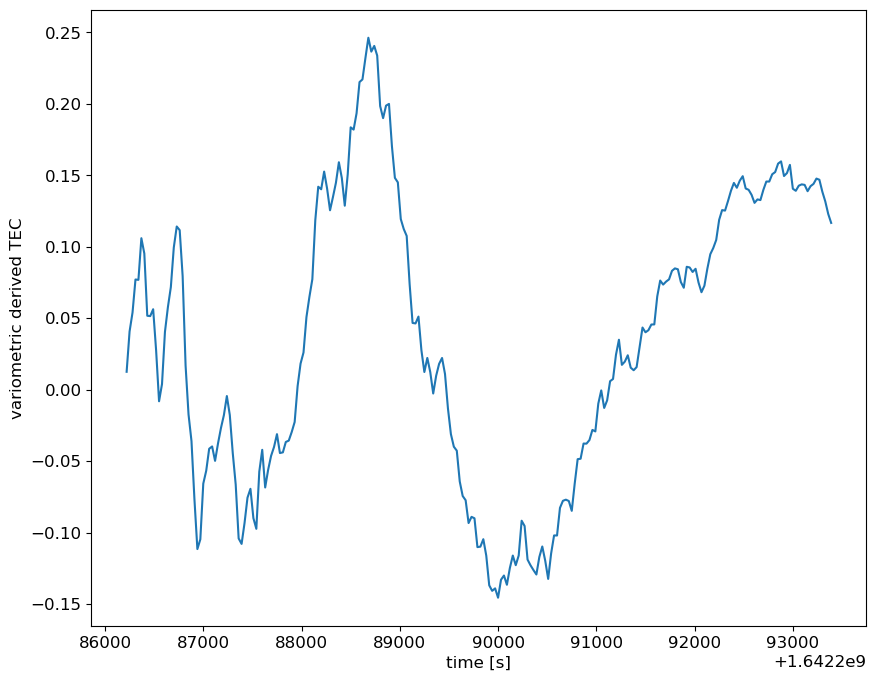

In [20]:
t = 2 *60*60 # in sec
t0 = df['time'][0] # first time stamp
t2 = t0 + t
print(t, t0, t2)
t2_idx = np.where(df.time == t2)[0] # index after two hour
plt.plot(df.time[0:t2_idx[0]], df.variometric_derived_TEC[0:t2_idx[0]])
plt.xlabel('time [s]')
plt.ylabel('variometric derived TEC')

In [21]:
df.iloc[t2_idx[0]] # to check if the satelite is stil the same as for df.iloc[t0] -> yes

GPS_seconds                                1326299820.0
satellite_number                                      1
variometric_derived_TEC                        0.116229
variometric_derived_TEC_filtered               0.001129
absolute_derived_TEC                           0.014963
absolute_derived_TEC_filtered                  0.005135
latitude_piercing_point                        -13.1891
longitude_piercing_point                        -169.92
satellite_azimuth                                 69.55
satellite_elevation_angle                         56.08
distance_to_piercing_point                       999.63
time                                       1642293420.0
datetime                            2022-01-16 00:37:00
Name: 240, dtype: object

## b. Get station info (0.5 point)
Get the station name by splitting the string of the file name and getting the charcater after "ioncorr". You can use the python function ``split()``.

In [22]:
# answer below
file_name = t_path.split('/')[-1]
sta = file_name.split('_')[1]
sta

'samo'

## c. Plot all data (2 points)
Make a plot of all vTEC filtered (``variometric_derived_TEC_filtered``) for each satellite. Align the data with the satellite number.

Use the ``plot_date`` function from matplotlib. Convert the Series ``time`` from a ``timestamp`` to an Numpy array of dtpe ``datetime64[s]`` (time stamps are in seconds, so we need to use ``[s]``). Plot the data for each sattelite observations.

In [23]:
# answer below
np_time = np.array(df.time,dtype='datetime64[s]') # from timestamp to datetime
print(type(np_time[0]))
np_time

<class 'numpy.datetime64'>


array(['2022-01-15T22:37:00', '2022-01-15T22:37:30',
       '2022-01-15T22:38:00', ..., '2022-01-15T20:08:30',
       '2022-01-15T20:09:00', '2022-01-15T20:09:30'],
      dtype='datetime64[s]')

In [24]:
df['time64'] = np_time
df['time64'].head()

Unnamed: 0
0   2022-01-15 22:37:00
1   2022-01-15 22:37:30
2   2022-01-15 22:38:00
3   2022-01-15 22:38:30
4   2022-01-15 22:39:00
Name: time64, dtype: datetime64[ns]

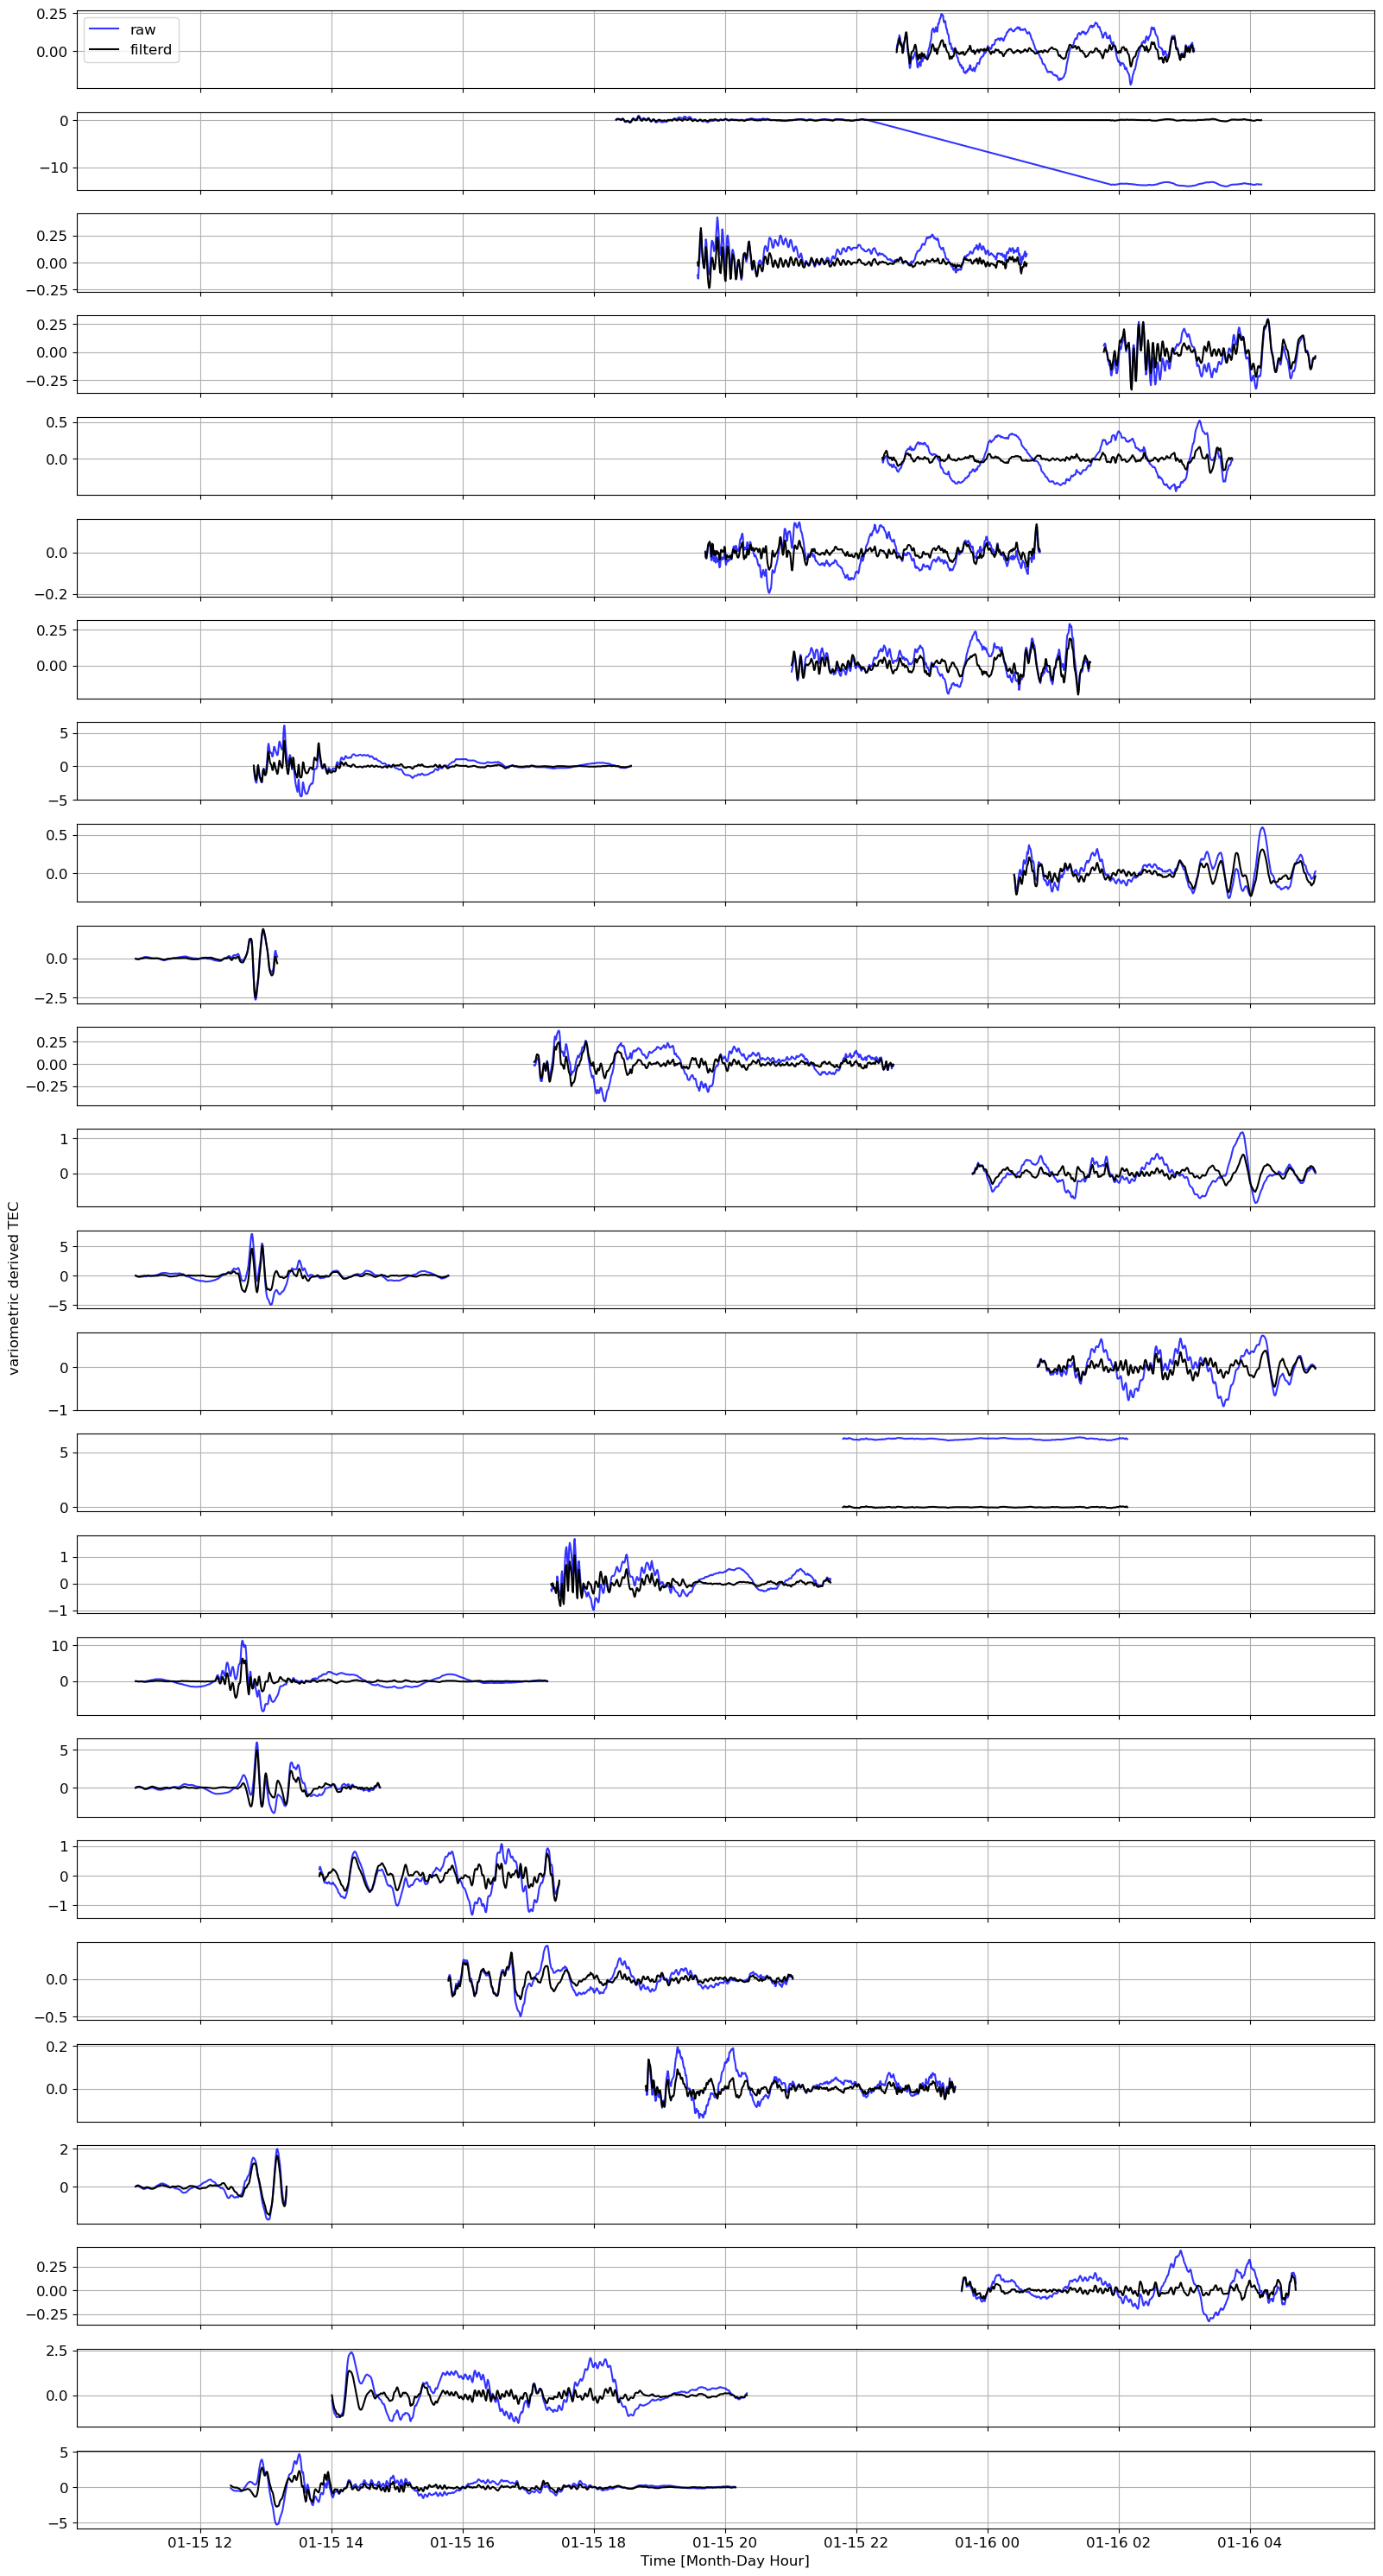

In [25]:
sat_l = np.unique(df.satellite_number) # list with the satellite numbers (each only once)
fig, ax = plt.subplots(len(sat_l), sharex=True, figsize=(16,30))

for i in range(len(sat_l)):
    df_cut = df[df.satellite_number == sat_l[i]]
    ax[i].plot_date(df_cut.time64, df_cut.variometric_derived_TEC, 'b', alpha=0.8, label='raw')
    ax[i].plot_date(df_cut.time64, df_cut.variometric_derived_TEC_filtered, 'k', label='filterd')
    ax[i].grid()
ax[0].legend(loc='upper left')
ax[i].set_xlabel('Time [Month-Day Hour]')
fig.text(0, 0.5, 'variometric derived TEC', va='center', rotation='vertical')
plt.tight_layout()

You can now select one of the satellite observations that contain a full vTEC signal.

## d. Wavelet transform (3 points)
You may choose a range of wavelet scales from 1 to 50 (write this as an array of integer), and call the ``cwt`` functions using the Morlet wavelet and taking the array of scales as an input argument. Plot it with an x-axis in time (hours) and y-axis in periods.

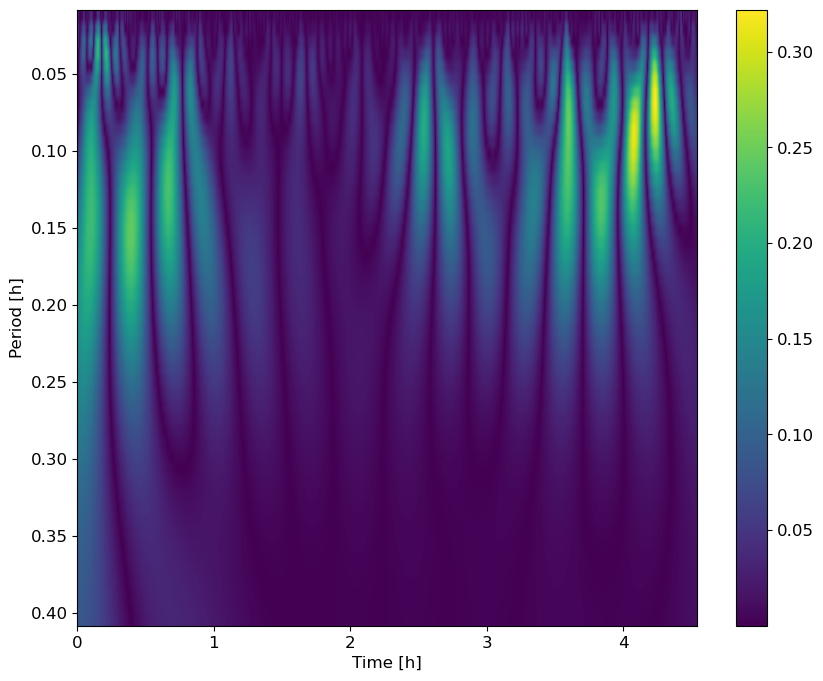

In [26]:
import scipy.signal as signal
# use the number of scales
w = range(1,50)
i = 0# choose satellite number
df_cut = df[df.satellite_number == sat_l[i]] 
dt = df_cut['datetime'].diff().median().total_seconds()
cwtmatr = signal.cwt(df_cut.variometric_derived_TEC_filtered, signal.ricker, w)
# this plot only shows the power
plt.imshow(np.abs(cwtmatr), cmap='viridis', aspect='auto', vmax=abs(cwtmatr).max(), vmin=abs(cwtmatr).min(),
                    extent=[0, len(df_cut)*dt/3600, w[-1]*dt/3600, w[0]*dt/3600])
plt.ylabel('Period [h]')
plt.xlabel('Time [h]')
#plt.yscale('log')
plt.colorbar()

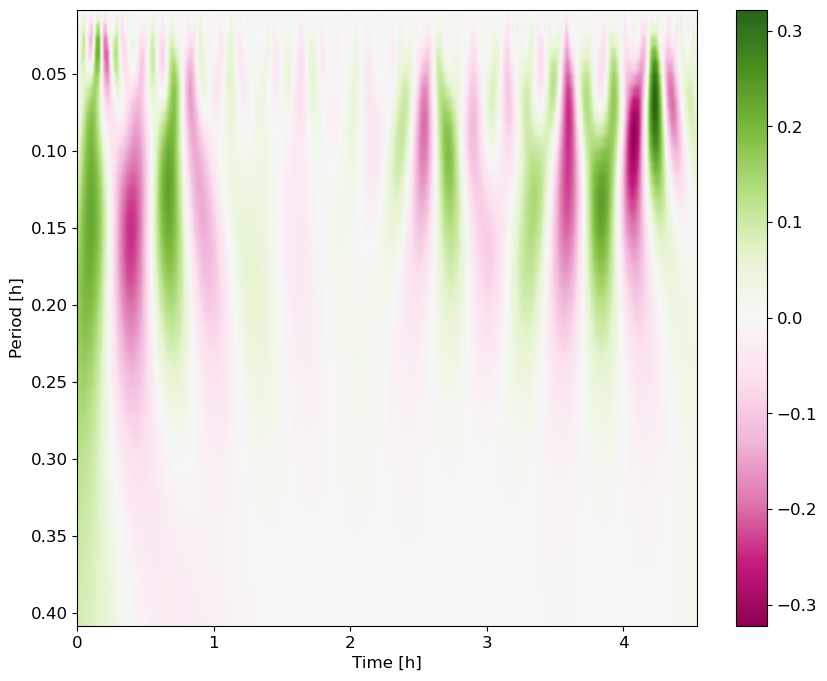

In [27]:
# this plot includes the phase
plt.imshow(cwtmatr, cmap='PiYG', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max(),
                    extent=[0, len(df_cut)*dt/3600, w[-1]*dt/3600, w[0]*dt/3600])
plt.ylabel('Period [h]')
plt.xlabel('Time [h]')
#plt.yscale('log')
plt.colorbar()

## e. Interpretation (0.5 points)
Can you describe the spectral features as a function of hours since the beginning of the time series? What periods dominate when?

#### answer
During the first hour, we see high power for the waves between 0.1 and 0.20 hour period and and higher frequenciese with a period around 0.04 h. Between 1 and two hour, the power over all periodes is low. Aftwer 2 hours the power slightly increases around 0.1 h period and decreases again and increases at 3.5 h. Than, the power is high while the period with the highest observed powers slightly increases from 0.15 h to 0.05 h.

The authors interpret the first packet as coming from a Lamb wave (a powerful gravity-acoustic wave that travel in the lower atmosphere), the second as coming from the tsunami disturbance.

## 3) 2D Spectral analysis of geological models (10 points)

In this exercise we will correlate water table level with surface elevation. You may download the data just like in the class. The file names are ``NCM_GeologicFrameworksGrids.nc`` and ``NCM_SpatialGrid.nc``.


In the following we will prepare our data.

In [1]:
# plotting modules
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,8) # set default figure size
plt.rcParams.update({'font.size': 12}) # set default font size

import numpy as np

In [64]:
# !pip install wget
# import wget
#file1 = wget.download("https://www.dropbox.com/s/wdb25puxh3u07dj/NCM_GeologicFrameworkGrids.nc?dl=1") #
file1 = "data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
#file2 = wget.download("https://www.dropbox.com/s/i6tv3ug15oe6yhe/NCM_SpatialGrid.nc?dl=1") 
file2 = "data/NCM_SpatialGrid.nc"
# Download the coordinate grids
#file3 = wget.download("https://www.dropbox.com/s/92m20pehfu7rxp2/NCM_AuxData.nc?dl=1") 
file3 = "data/NCM_AuxData.nc"

In [65]:
# ansert below
import netCDF4 as nc
nc_file1 = nc.Dataset(file1, mode='r')
nc_file2 = nc.Dataset(file2, mode='r')
nc_file3 = nc.Dataset(file3, mode='r')
print(nc_file1.variables.keys())
print(nc_file2.variables.keys())
print(nc_file3.variables.keys())

dict_keys(['Notes', 'Surface Elevation', 'Bedrock Elevation', 'Bottom Cenozoic Elevation', 'Bottom Phanerozoic Elevation', 'Mid Crustal Elevation', 'Moho Elevation', 'Top Ocean Plate Elevation'])
dict_keys(['Notes', 'x', 'y', 'Latitude vector', 'Longitude vector', 'Index j grid', 'Index k grid'])
dict_keys(['Water table depth file', 'Slopes file', 'Notes', 'Water Table Depth', 'Calibration Slope', 'Calibration Offset'])


**a. Plot (2 points)**

Plot the data ``WT`` and ``elevation``. Use ``contourf``,``x`` and ``y`` as lat-long variables. You can use ``levels``  to split the color map, and ``alpha`` less than 1 to increase transparency.

In [4]:
# answer below --> too big data set (kernel dies)
# create a grid of latitude and longitude
x = nc_file2['x'][0:4901, 0:3201]
y = nc_file2['y'][0:4901, 0:3201]
WT = nc_file3['Water Table Depth'][0:4901, 0:3201]
elevation = nc_file1['Surface Elevation'][0:4901, 0:3201]

In [15]:
# answer below --> only a subset
cut = 1000
# create a grid of latitude and longitude
x = nc_file2['x'][0:cut, 0:cut]
y = nc_file2['y'][0:cut, 0:cut]
WT = nc_file3['Water Table Depth'][0:cut, 0:cut]
elevation = nc_file1['Surface Elevation'][0:cut, 0:cut]

In [16]:
masked_WT = np.ma.masked_where(WT <= 0.1, WT) # mask values smaller than 0.01 for plotting
masked_WT

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., 78.2816390991211, 100.0327377319336,
         137.20664978027344],
        [--, --, --, ..., 71.69917297363281, 86.4426040649414,
         106.0918197631836],
        [--, --, --, ..., 64.79407501220703, 72.48023223876953,
         75.10792541503906]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)

In [44]:
# answer below
# create a grid of latitude and longitude
lat = nc_file2['Latitude vector'][0:nc_file2['Latitude vector'].shape[0]]
lon = nc_file2['Longitude vector'][0:nc_file2['Longitude vector'].shape[0]]
# WT = nc_file3['Water Table Depth'][0:nc_file2['Latitude vector'].shape[0], 0:nc_file2['Longitude vector'].shape[0]]
# elevation = nc_file1['Surface Elevation'][0:4901, 0:3201]
print(lat[0],lon[0], lat[-1],lon[-1], lat.shape, lon.shape)

# define lat and lon array
my_lat = np.linspace(lat[0],lat[-1],3201) # vertical
my_lon = np.linspace(lon[0],lon[-1],4901) # horizontal
print(my_lat.shape, my_lon.shape)
my_lat_crop = my_lat[:cut]
my_lon_crop = my_lon[:cut]
print(my_lat_crop.shape, my_lon_crop.shape)

21.92206382751465 -129.72398376464844 52.92206573486328 -63.623985290527344 (311,) (662,)
(3201,) (4901,)
(1000,) (1000,)


Text(0, 0.5, 'Lon')

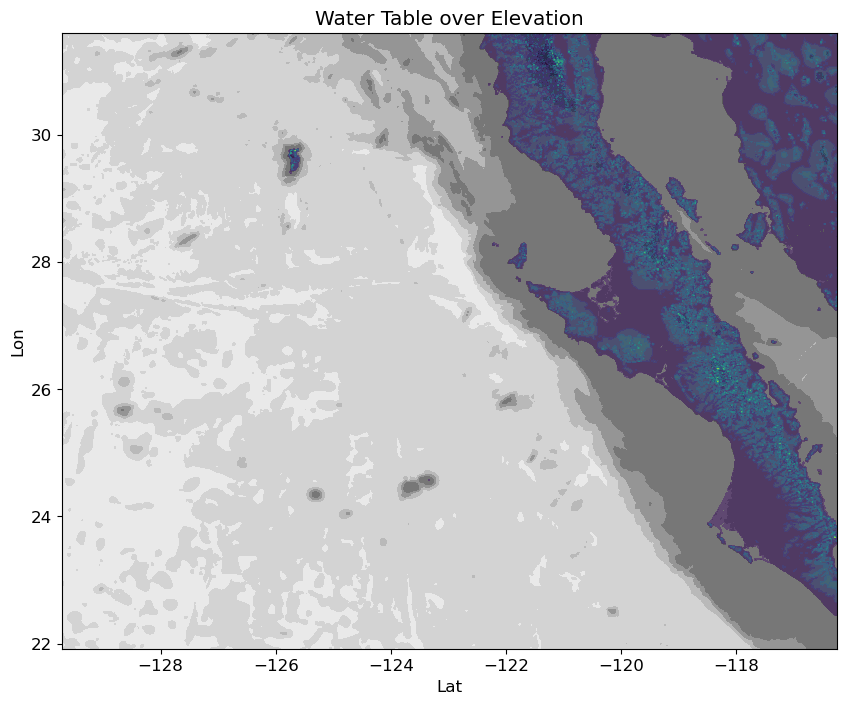

In [79]:
# answer below (only a subset of map, lower left corner)
plt.contourf(my_lon_crop, my_lat_crop, np.transpose(elevation),cmap='Greys')
# define color map
cmap = plt.cm.get_cmap('viridis') # for data use colormap viridis
cmap.set_bad(color='black', alpha=0) # make masked data transparent
plt.contourf(my_lon_crop, my_lat_crop, np.transpose(masked_WT), cmap=cmap, alpha=0.5)
plt.title('Water Table over Elevation')
plt.xlabel('Lat')
plt.ylabel('Lon')

In [ ]:
# answer below for whole map (I could not test it)
plt.contourf(my_lon, my_lat, np.transpose(elevation),cmap='Greys')
# define color map
cmap = plt.cm.get_cmap('viridis') # for data use colormap viridis
cmap.set_bad(color='black', alpha=0) # make masked data transparent
plt.contourf(my_lon, my_lat, np.transpose(masked_WT), cmap=cmap, alpha=0.5)
plt.title('Water Table over Elevation')
plt.xlabel('Lat')
plt.ylabel('Lon')

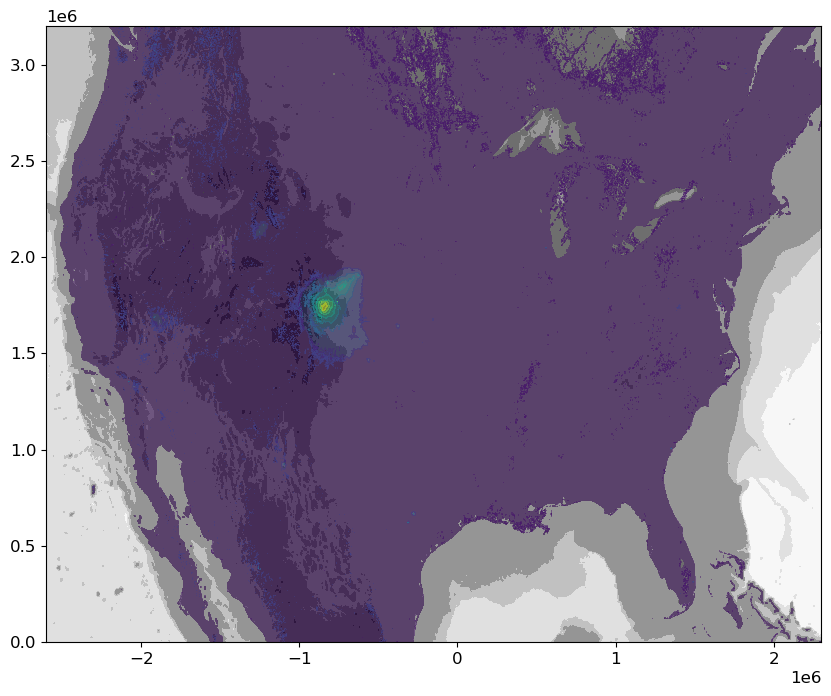

In [7]:
# answer below
plt.contourf(x, y, elevation,cmap='Greys')#, extend=[lat[0],lat[-1],lon[0],lon[-1]])
# define color map
cmap = plt.cm.get_cmap('viridis') # for data use colormap viridis
cmap.set_bad(color='black', alpha=0) # make masked data transparent
plt.contourf(x, y, masked_WT, cmap=cmap, alpha=0.5)#, extend=[lat[0],lat[-1],lon[0],lon[-1]])

In [ ]:
# # answer below
# plt.contourf(lon, lat, elevation)
# #plt.contourf(lon, lat, WT)

**b. Perform and plot the 2D Fourier transforms (4 points)**

In [68]:
# # answer below
# from scipy.fftpack import fft2, fftfreq,fftshift
# import matplotlib.cm as cm
# fft2_WT = fft2(WT)
# fft2_elevation = fft2(elevation)
# print(fft2_WT.shape, fft2_elevation.shape)
# f_WT_shift = fftshift(fft2_WT)
# f_elevation_shift = fftshift(fft2_elevation)

(1000, 1000) (1000, 1000)


this is about the spatial sampling of the model  1.5007397612756534  km
this is about the spatial sampling of the model  1.0777344413103096  km


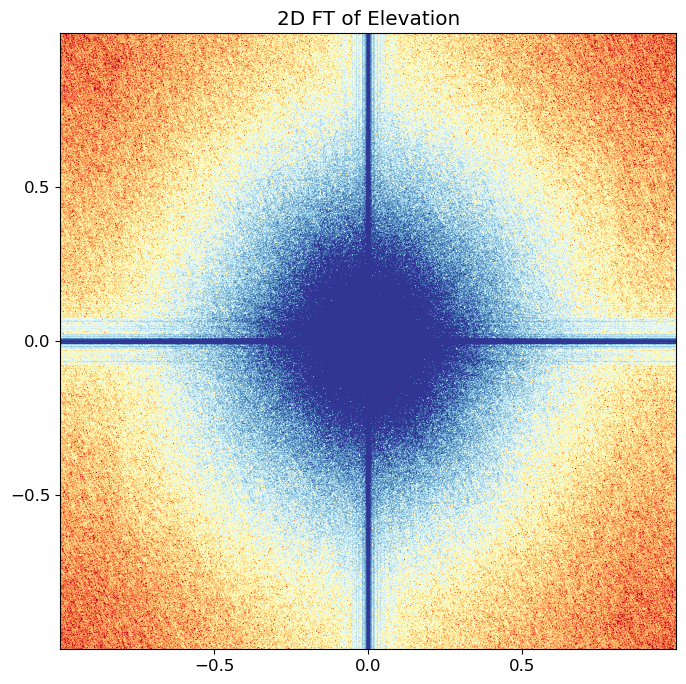

this is about the spatial sampling of the model  1.5007397612756534  km
this is about the spatial sampling of the model  1.0777344413103096  km


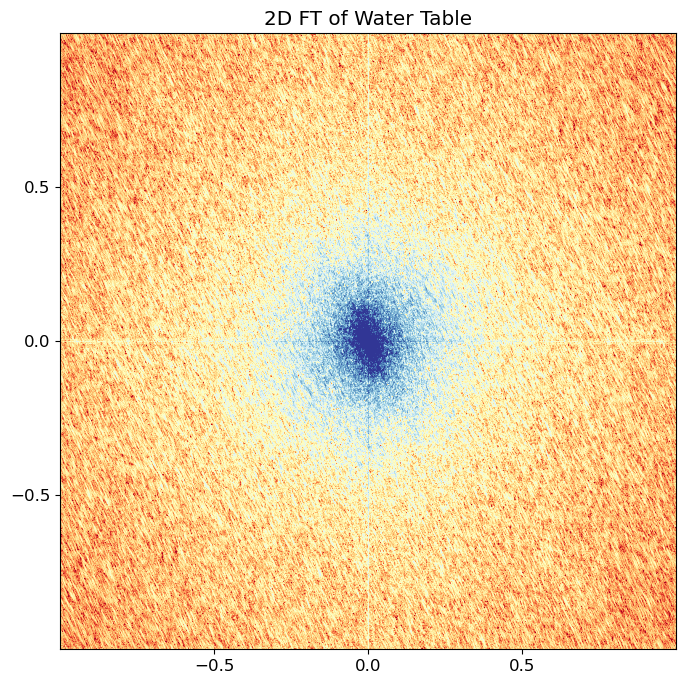

In [74]:
from scipy.fftpack import fft2, fftfreq,fftshift, ifft2
import matplotlib.cm as cm
fft = []
for data_m, color, title in zip([elevation, WT],['Greys','viridis'],['Elevation','Water Table']):
    Zel = fft2(data_m)
    fft.append(Zel)
    # make a vector of distances. Here I will ignore the curvature and spatial projection.
    # make the wavenumber frequency vector: 
    Rlon = (my_lon_crop-np.min(my_lon_crop))*111.25  # convert degrees to kms
    drlon = Rlon[1]-Rlon[0]
    print("this is about the spatial sampling of the model ",drlon," km")
    klon = (fftfreq( 4901//2 , drlon  ))


    Rlat = (my_lat_crop-np.min(my_lat_crop))*111.25  # convert degrees to kms
    drlat = Rlat[1]-Rlat[0]
    print("this is about the spatial sampling of the model ",drlat," km")
    klat = (fftfreq( 3201//2 , drlat  ))

    # amplitude of the DEM
    plt.imshow(fftshift(np.log10(np.abs(Zel)/Zel.size)),vmin=-3, vmax=-1, cmap='RdYlBu',extent=[-1,1,-1,1])
    plt.title('2D FT of {}'.format(title))
    x_label_list = ['-1/3 km$^{-1}$','0','1/3  km$^{-1}$']
    plt.xticks([-0.5,0,0.5])
    plt.yticks([-0.5,0,0.5])
    plt.show()

**c. Interpretation (1 point)**

Comment on the wavelengths that dominate the DEM and the water table wavelengths

### answer
Code for fourie transform is in next subsection. I did the fourie transform and the lowpass filter within a loop, that is why. The median of teh elevation is 413, the median of the water table is 0.048095703.

**d. 2D filtering (3 points)**

Find a way to low pass filter the image (spectral filtering or convolution)

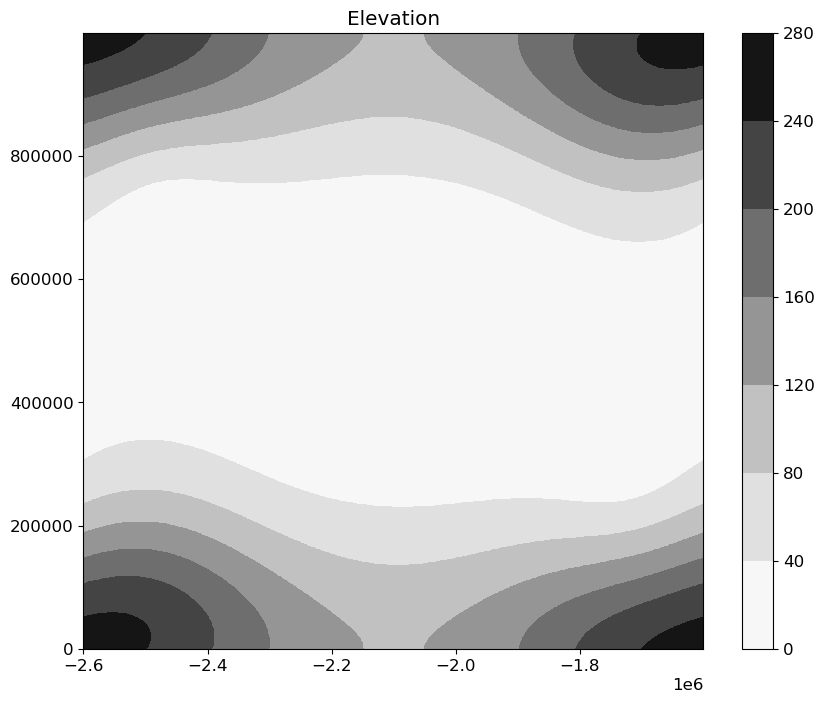

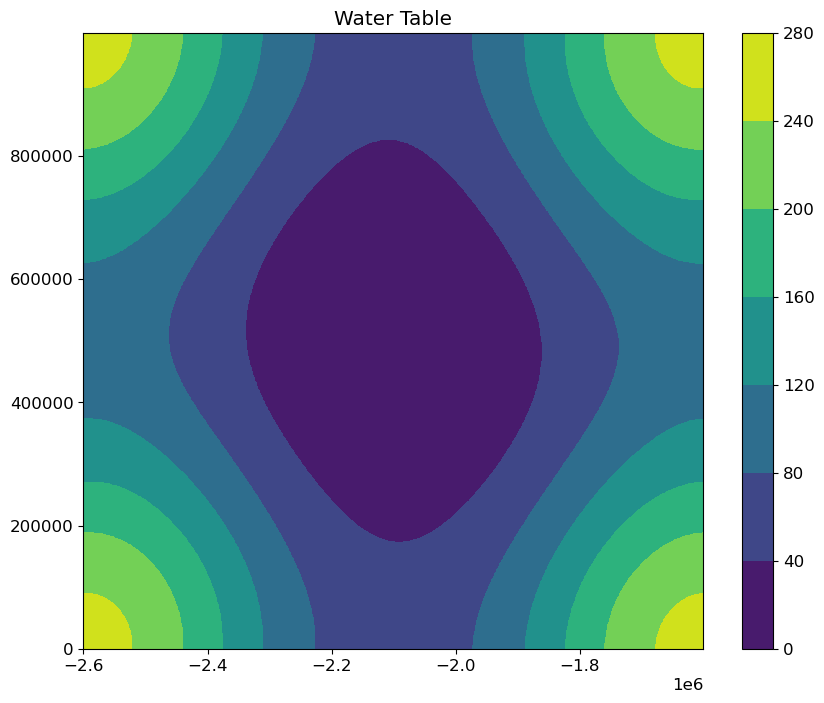

In [27]:
# for data_m, color, title in zip([elevation, WT],['Greys','viridis'],['Elevation','Water Table']):
#     r = 1e5 # how narrower the window is
#     ham = np.hamming(1000)[:,None] # 1D hamming
#     ham2d = np.sqrt(np.dot(ham, ham.T)) ** r # expand to 2D hamming
#     f_shifted = np.fft.fftshift(data_m)
#     f_complex = f_shifted[:,:]*1j + f_shifted[:,:]
#     f_filtered = ham2d * f_complex
#     f_filtered_shifted = np.fft.fftshift(f_filtered)
#     inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
#     filtered_img = np.abs(inv_img)
#     filtered_img -= filtered_img.min()
#     filtered_img = filtered_img*255 / filtered_img.max()
#     filtered_img = filtered_img.astype(np.uint8)
#     plt.contourf(x, y, filtered_img,cmap=color)
#     plt.colorbar()
#     plt.title(title)
#     plt.show()

In [32]:
!pip install imageio

  Using cached imageio-2.22.4-py3-none-any.whl (3.4 MB)


(413.57483+0j)


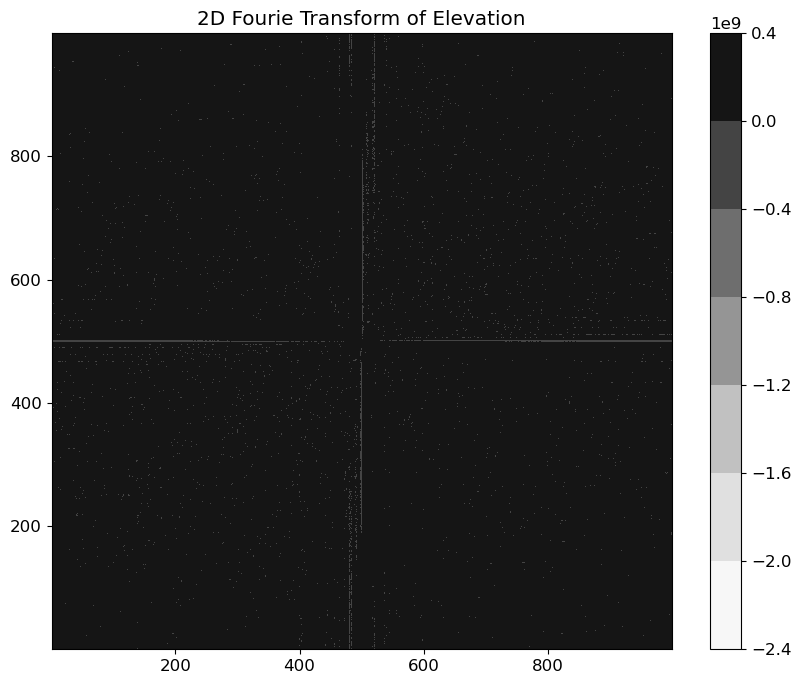

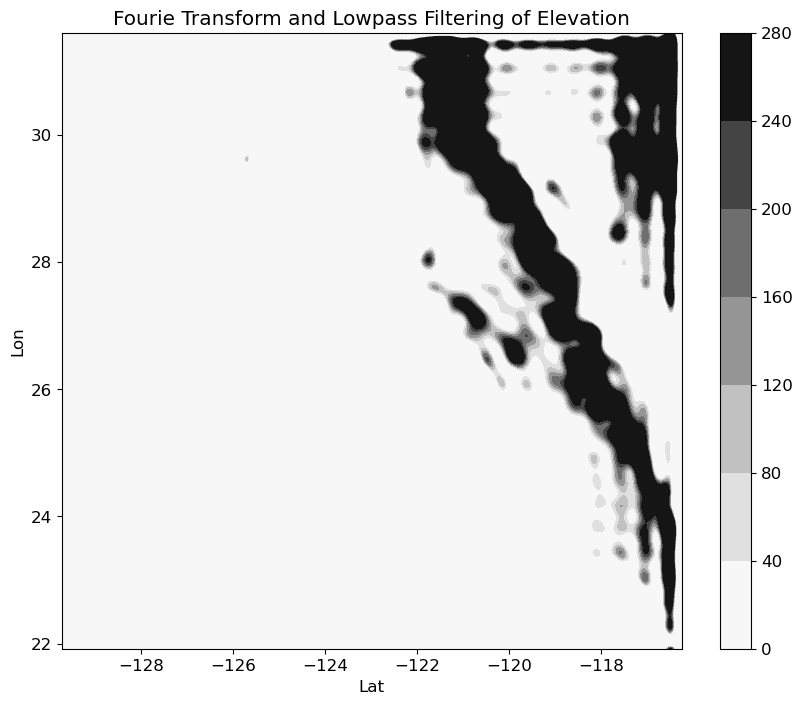

(0.048095703+0j)


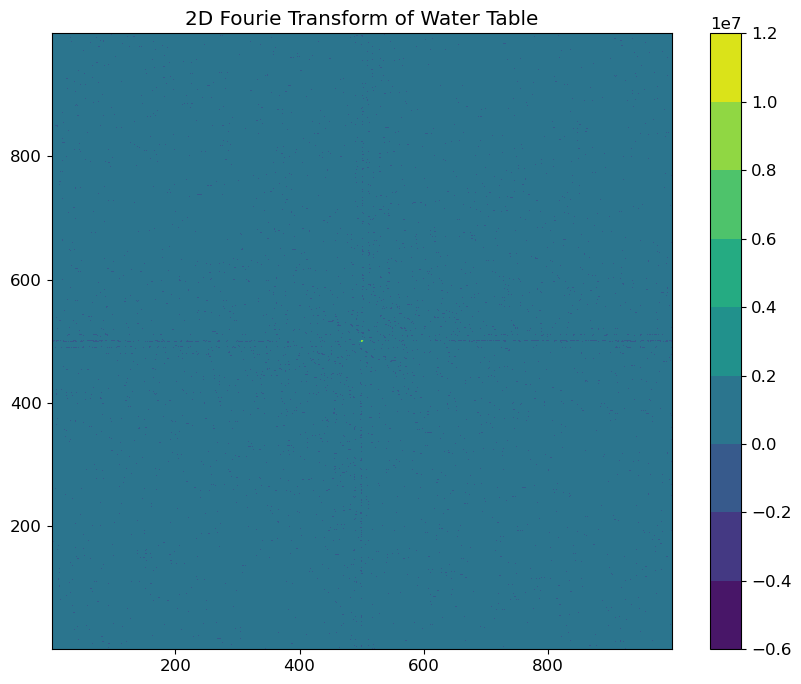

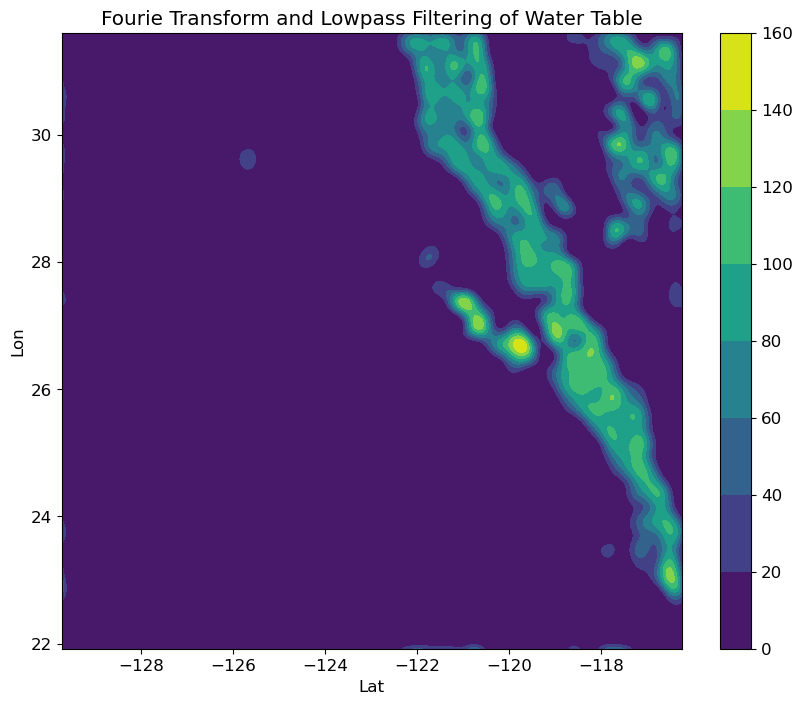

In [77]:
from scipy import fftpack
import numpy as np
import imageio
from PIL import Image, ImageDraw

for data_m, color, title in zip([elevation, WT],['Greys','viridis'],['Elevation','Water Table']):

    #convert image to numpy array
    image1_np = data_m

    #fft of image
    fft1 = fftpack.fftshift(fftpack.fft2(image1_np))
    print(np.median(fft1))
    
    plt.contourf(np.transpose(fft1), origin='lower', cmap=color)#, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title('2D Fourie Transform of {}'.format(title))
    plt.show()

    #Create a low pass filter image
    x,y = image1_np.shape[0],image1_np.shape[1]
    #size of circle
    e_x,e_y=50,50
    #create a box 
    bbox=((x/2)-(e_x/2),(y/2)-(e_y/2),(x/2)+(e_x/2),(y/2)+(e_y/2))

    low_pass=Image.new("L",(image1_np.shape[0],image1_np.shape[1]),color=0)

    draw1=ImageDraw.Draw(low_pass)
    draw1.ellipse(bbox, fill=1)

    low_pass_np=np.array(low_pass)

    #multiply both the images
    filtered=np.multiply(fft1,np.transpose(low_pass_np))

    #inverse fft
    ifft2 = np.real(fftpack.ifft2(fftpack.ifftshift(filtered)))
    ifft2 = np.maximum(0, np.minimum(ifft2, 255))
    plt.contourf(my_lon_crop, my_lat_crop,np.transpose(ifft2), origin='lower', cmap=color)
    plt.colorbar()
    plt.title('Fourie Transform and Lowpass Filtering of {}'.format(title))
    plt.xlabel('Lat')
    plt.ylabel('Lon')
    plt.show()

Now we will filter or compress by taking the largest Fourier coefficients of the image.

In [64]:
# Sort the Fourier coefficients
Zsort = np.sort(np.abs(np.abs(fft[0]).reshape(-1))) # elevation
Wsort = np.sort(np.abs(np.abs(fft[1]).reshape(-1))) # Water Tabel
print(len(Zsort))
print(Zsort.shape)
Zsort

1000000
(1000000,)


array([1.5109837e+01, 1.5109837e+01, 2.1811533e+01, ..., 9.4089690e+08,
       9.4089690e+08, 2.3989745e+09], dtype=float32)

Plot and reconstruct the image of the water table map with 1% until 10% of the data (like in class)

In [70]:
Alow.shape

(1000, 1000)

We are keeping up to 0.010000 the number of Fourier coefficients


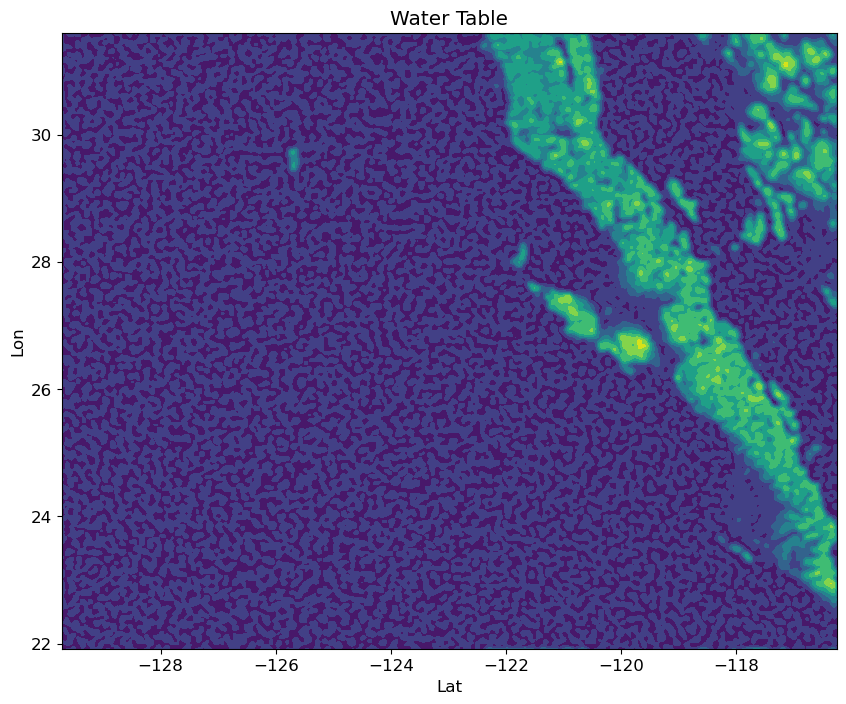

In [88]:
#answer
from scipy.fftpack import fft2, fftfreq,fftshift, ifft2
from IPython import display
import time

Alow_l = []

for sort, fft_i, color, title in zip([Zsort,Wsort],[fft[0],fft[1]],['Greys','viridis'],['Elevation','Water Table']):
    for keep in (0.1,0.05,0.01):
        display.clear_output(wait=True)
        thresh = sort[int(np.floor( (1-keep)*len(sort) ))]
        ind = np.abs(fft_i)>thresh
        Atlow = fft_i * ind # here we zero out the matrix
        # Here we count the number of non-zeros in the matrix
        print("We are keeping up to %f the number of Fourier coefficients" % keep)
        Alow = ifft2(Atlow).real
        Alow_l.append(Alow)

        plt.contourf(my_lon_crop, my_lat_crop, np.transpose(Alow), cmap=color)
        plt.title('{}'.format(title))
        plt.xlabel('Lat')
        plt.ylabel('Lon')
        plt.show()
        time.sleep(1)

Now we will compare the original 2D data set with the Fourier compressed data


Text(0, 0.5, 'Lon')

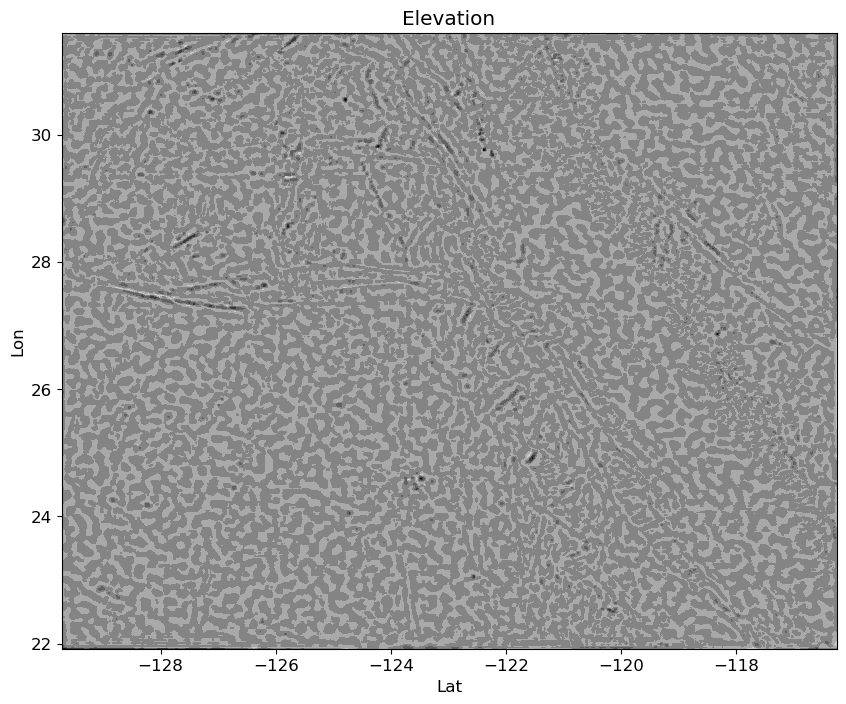

In [99]:
# answer below
# elevation
plt.contourf(my_lon_crop, my_lat_crop, np.transpose(np.subtract(elevation,Alow_l[2])), cmap='Greys')
plt.title('Elevation')
plt.xlabel('Lat')
plt.ylabel('Lon')

Text(0, 0.5, 'Lon')

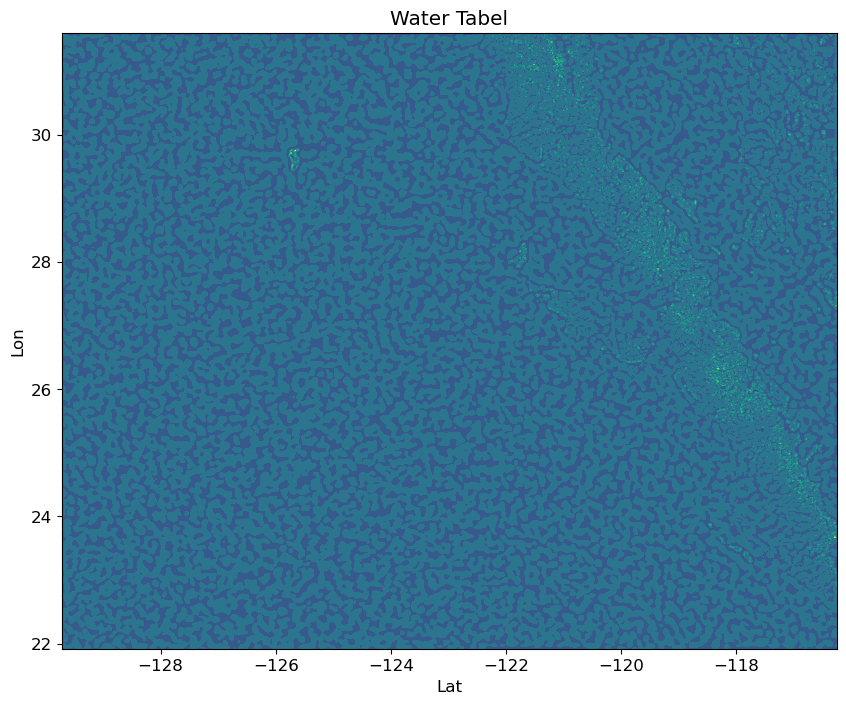

In [100]:
# water tabel
plt.contourf(my_lon_crop, my_lat_crop, np.transpose(np.subtract(WT,Alow_l[5])), cmap='viridis')
plt.title('Water Tabel')
plt.xlabel('Lat')
plt.ylabel('Lon')